In [56]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.filters import threshold_otsu
import seaborn as sns
from skimage.color import rgb2gray
from skimage.morphology import convex_hull_image
from scipy.spatial import ConvexHull
from skimage.measure import label, regionprops
from skimage.draw import polygon,rectangle,polygon_perimeter
import math
import csv
import os
import sklearn
import pandas as pd
from scipy.stats import f_oneway
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_1samp

In [57]:
file_path = r"data_2\dataset.csv"
data = pd.read_csv(file_path)

In [58]:
data.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
0,0.184,106401.5980,103157.1785,1293.4311,592,1150,0.7705,0.2313,0.018043
1,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313,0.018043
2,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313,0.000000
3,0.184,106400.7710,103156.2771,1293.4311,592,1150,0.7705,0.2313,0.008414
4,0.184,106402.8029,103158.1105,1293.4311,592,1150,0.7705,0.2313,0.008564


In [59]:
data.tail()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
295,0.1387,92597.5043,90066.2099,1181.6302,449,1093,0.7577,0.1645,0.000000
296,0.1386,92571.9423,90039.6155,1181.6302,449,1093,0.7579,0.1644,0.035456
297,0.1386,92571.9423,90039.6155,1181.6302,449,1093,0.7579,0.1644,0.000000
298,0.1387,92597.5043,90066.2099,1181.6302,449,1093,0.7577,0.1645,0.035456
299,0.1386,92571.9423,90039.6155,1181.6302,449,1093,0.7579,0.1644,0.035456


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  300 non-null    float64
 1   Feature2  300 non-null    float64
 2   Feature3  300 non-null    float64
 3   Feature4  300 non-null    float64
 4   Feature5  300 non-null    int64  
 5   Feature6  300 non-null    int64  
 6   Feature7  300 non-null    float64
 7   Feature8  300 non-null    float64
 8   Feature9  300 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 21.2 KB


In [61]:
data.shape

(300, 9)

In [62]:
data.isnull().sum()

Feature1    0
Feature2    0
Feature3    0
Feature4    0
Feature5    0
Feature6    0
Feature7    0
Feature8    0
Feature9    0
dtype: int64

In [63]:
d=data.describe().T.drop(["25%"	,"50%"	,"75%",'count'],axis=1)
d=d[['min','max','mean','std']]
d

,min,max,mean,std
Feature1,0.1121,0.190300,0.152698,0.020580
Feature2,83528.1779,108193.522600,96826.305201,6497.177463
Feature3,80950.3309,103158.110500,92651.430769,5500.413412
Feature4,1156.8513,1293.431100,1215.729927,42.300775
Feature5,412.0000,592.000000,466.726667,37.045465
Feature6,1080.0000,1174.000000,1122.213333,34.962682
Feature7,0.7294,0.789700,0.758105,0.012816
Feature8,0.1298,0.239900,0.184671,0.028877
Feature9,0.0000,11.550129,0.752736,2.131414


In [64]:
import matplotlib.pyplot as plt

def ploty(x, y, size1=10, size2=1.5, interval=10, title="plotting", x_ticks_positions=90):
    """
    Function to plot x vs. y with customizable figure size, x-tick positions, and axis labels.
    
    Parameters:
    - x: x-axis data
    - y: y-axis data
    - size1: Width of the plot
    - size2: Height of the plot
    - interval: Interval for x-tick positions
    - title: Title of the plot
    - x_ticks_positions: Rotation angle for x-axis labels
    """
    # Create a single plot
    plt.figure(figsize=(size1, size2*2))
    
    # Plot the data
    plt.plot(x, y)
    total_data_points = len(x)
    interval = total_data_points // interval
    x_ticks = x[::interval]  # Calculate positions for x-ticks
    plt.xticks(ticks=x_ticks, rotation=x_ticks_positions)  # Rotate x-axis labels
    
    # Add labels, legend, and title
    if hasattr(y, 'columns'):  # Check if y has column names
        plt.legend(y.columns)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(title)
    plt.grid()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming x and y are defined:
# ploty(x, y)

In [65]:
data.columns

Index(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6',
       'Feature7', 'Feature8', 'Feature9'],
      dtype='object')

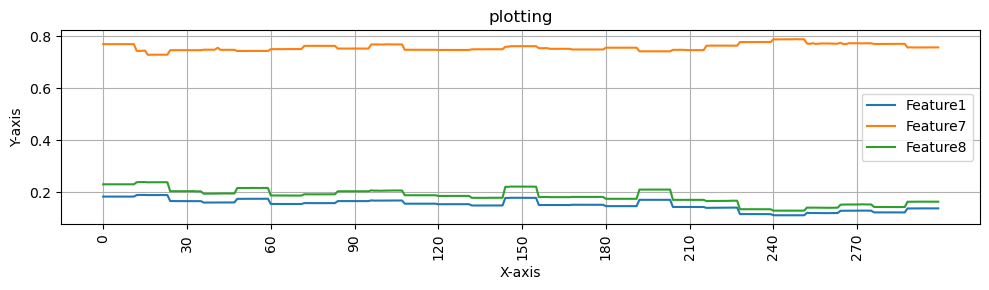

In [66]:
ploty(data.index,data[["Feature1","Feature7","Feature8"]])

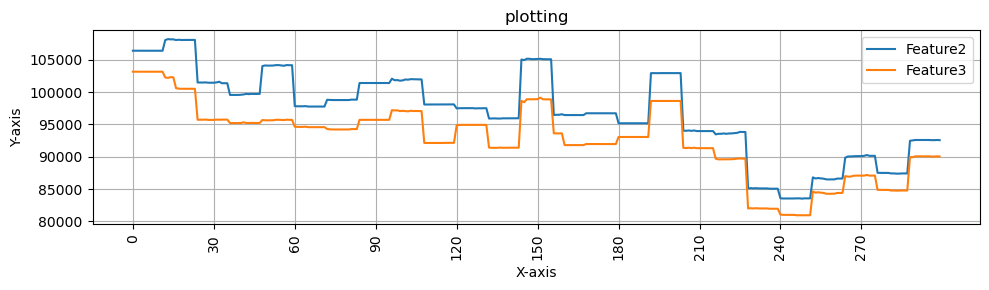

In [67]:
ploty(data.index,data[["Feature2","Feature3"]])

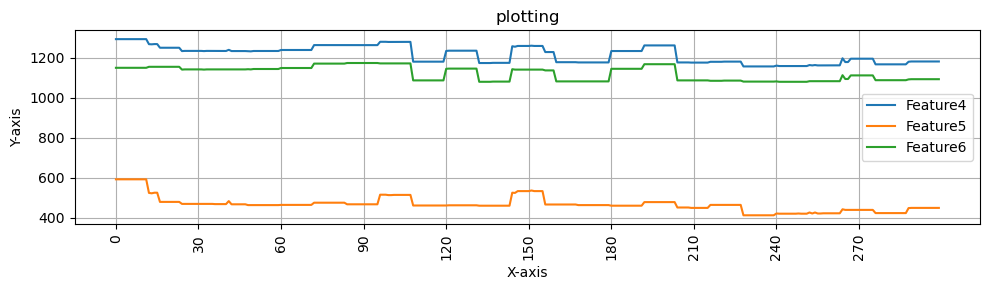

In [68]:
ploty(data.index,data[["Feature4","Feature5","Feature6"]])

In [69]:
def detect_outliers(dataset_features):
    """
    Detect outliers in the dataset using the Interquartile Range (IQR) method.

    Args:
        dataset_features (pd.DataFrame): Input DataFrame containing numerical features to analyze

    Returns:
        pd.DataFrame: DataFrame containing for each feature:
            - Lower Bound: Q1 - 1.5*IQR threshold for outliers
            - Upper Bound: Q3 + 1.5*IQR threshold for outliers
            - Outliers Count: Number of values outside the bounds
    Notes:
        - Uses the standard 1.5*IQR rule: points below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are considered outliers
    """
    outliers = pd.DataFrame(index=dataset_features.columns)
    # Calculate quantiles
    Q1 = dataset_features.quantile(0.25)
    Q3 = dataset_features.quantile(0.75)
    # Calculate IQR range
    IQR = Q3 - Q1
    # Define upper and lower bounds
    outliers['Lower Bound'] = Q1 - 1.5*IQR
    outliers['Upper Bound'] = Q3 + 1.5*IQR
    # Calculate the count of outliers
    outliers['Outliers Count'] = [
        ((dataset_features[col] < outliers.loc[col, 'Lower Bound']) |
         (dataset_features[col] > outliers.loc[col, 'Upper Bound'])).sum()
        for col in dataset_features.columns
    ]
    return outliers

detect_outliers(data)

,Lower Bound,Upper Bound,Outliers Count
Feature1,0.102300,0.205500,0
Feature2,81650.779450,113393.307050,0
Feature3,81528.680000,104224.508000,12
Feature4,1058.055600,1374.973200,0
Feature5,419.000000,499.000000,52
Feature6,991.500000,1243.500000,0
Feature7,0.717250,0.800850,0
Feature8,0.110663,0.261162,0
Feature9,-0.372764,0.621273,44


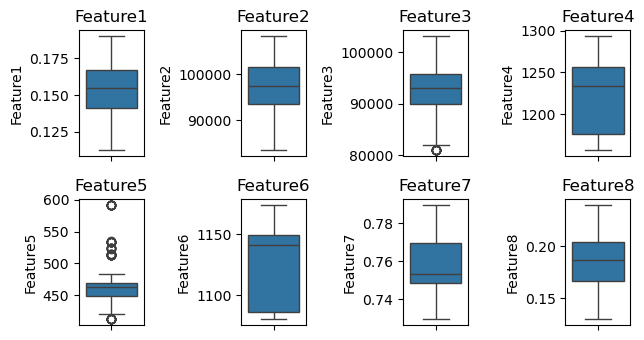

In [70]:
plt.figure(figsize=(6.5,3.5))
for i, col in enumerate(data[["Feature1","Feature2","Feature3","Feature4","Feature5","Feature6","Feature7","Feature8"]], 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=data[col])
    plt.title(col)

plt.tight_layout()
plt.show()

<Axes: >

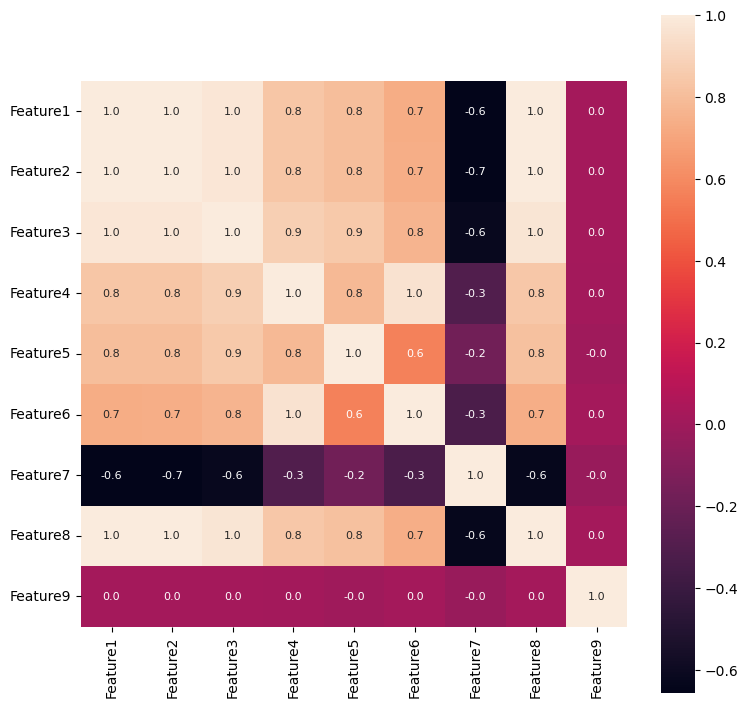

In [71]:
correlation = data.corr()
plt.figure(figsize = (8.8,8.8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8})
     

In [72]:
correlation

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
Feature1,1.000000,0.999363,0.976327,0.835763,0.805823,0.732526,-0.649480,0.999064,0.019372
Feature2,0.999363,1.000000,0.977059,0.836432,0.801442,0.735667,-0.655529,0.997620,0.019696
Feature3,0.976327,0.977059,1.000000,0.876571,0.851125,0.764334,-0.618762,0.973963,0.017701
Feature4,0.835763,0.836432,0.876571,1.000000,0.781758,0.956131,-0.304579,0.841160,0.013321
Feature5,0.805823,0.801442,0.851125,0.781758,1.000000,0.565081,-0.174451,0.812759,-0.000004
Feature6,0.732526,0.735667,0.764334,0.956131,0.565081,1.000000,-0.330441,0.735933,0.018974
Feature7,-0.649480,-0.655529,-0.618762,-0.304579,-0.174451,-0.330441,1.000000,-0.629923,-0.026421
Feature8,0.999064,0.997620,0.973963,0.841160,0.812759,0.735933,-0.629923,1.000000,0.018108
Feature9,0.019372,0.019696,0.017701,0.013321,-0.000004,0.018974,-0.026421,0.018108,1.000000


The correlation matrix reveals strong positive relationships among many features, especially between Features 1, 2, and 8, indicating they likely capture similar patterns. Features 3 and 4 also show a strong positive correlation. Feature7, however, exhibits moderate negative correlations with several other features, suggesting an inverse relationship or a unique role in the dataset. Overall, the dataset appears to have highly interrelated features, with some, like Feature7, displaying contrasting behavior. These insights suggest potential redundancy among features

In [73]:
l:list = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6',
        'Feature8','Feature9']


In [74]:
# Perform one-way ANOVA across all features
f_stat, p_value = f_oneway(*[data[col].values for col in l])

# Display results
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Significant differences exist between the features.")
else:
    print("No significant differences between the features.")

F-Statistic: 63114.40
P-Value: 0.0000
Significant differences exist between the features.


In [75]:
# Generate all unique pairs of columns from 'l'
pairwise_results:list = []
for feature1, feature2 in combinations(l, 2):
    # Perform t-test
    t_stat, p_value = ttest_ind(data[feature1], data[feature2])
    pairwise_results.append({
        'Feature Pair': f'{feature1} vs {feature2}',
        'T-statistic': t_stat,
        'P-value': p_value
    })

# Convert the results to a DataFrame
pairwise_results_df = pd.DataFrame(pairwise_results)

# Print the results
print(pairwise_results_df)

            Feature Pair  T-statistic        P-value
0   Feature1 vs Feature2  -258.124111   0.000000e+00
1   Feature1 vs Feature3  -291.753926   0.000000e+00
2   Feature1 vs Feature4  -497.731134   0.000000e+00
3   Feature1 vs Feature5  -218.145375   0.000000e+00
4   Feature1 vs Feature6  -555.868598   0.000000e+00
5   Feature1 vs Feature8   -15.616924   2.308055e-46
6   Feature1 vs Feature9    -4.875861   1.390200e-06
7   Feature2 vs Feature3     8.494373   1.580998e-16
8   Feature2 vs Feature4   254.878161   0.000000e+00
9   Feature2 vs Feature5   256.876119   0.000000e+00
10  Feature2 vs Feature6   255.129170   0.000000e+00
11  Feature2 vs Feature8   258.124026   0.000000e+00
12  Feature2 vs Feature9   258.122497   0.000000e+00
13  Feature3 vs Feature4   287.917625   0.000000e+00
14  Feature3 vs Feature5   290.278126   0.000000e+00
15  Feature3 vs Feature6   288.214795   0.000000e+00
16  Feature3 vs Feature8   291.753826   0.000000e+00
17  Feature3 vs Feature9   291.752015   0.0000

Segregating the Data points as in terms of Annual indexing, asuming 8 frames per year (Please refer to resource 1)

In [76]:
# Assuming your dataset is loaded in the variable data
# Example: data = pd.DataFrame(...)

# Generate the years based on the number of rows and rows per year
start_year = 1984
rows_per_year = 8
total_rows = len(data)

# Calculate the year for each row
years = [start_year + (i // rows_per_year) for i in range(total_rows)]

# Add the 'Year' column to the dataset
data['Year'] = years

# Print the first few rows to verify

data.tail()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Year
295,0.1387,92597.5043,90066.2099,1181.6302,449,1093,0.7577,0.1645,0.000000,2020
296,0.1386,92571.9423,90039.6155,1181.6302,449,1093,0.7579,0.1644,0.035456,2021
297,0.1386,92571.9423,90039.6155,1181.6302,449,1093,0.7579,0.1644,0.000000,2021
298,0.1387,92597.5043,90066.2099,1181.6302,449,1093,0.7577,0.1645,0.035456,2021
299,0.1386,92571.9423,90039.6155,1181.6302,449,1093,0.7579,0.1644,0.035456,2021


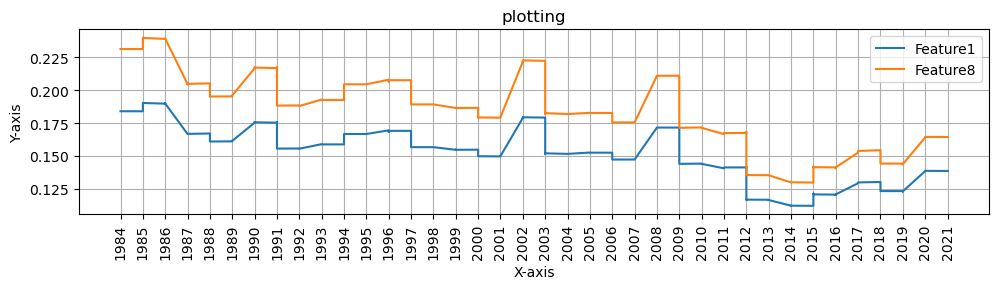

In [77]:
ploty(data["Year"],data[["Feature1","Feature8"]], interval=35)

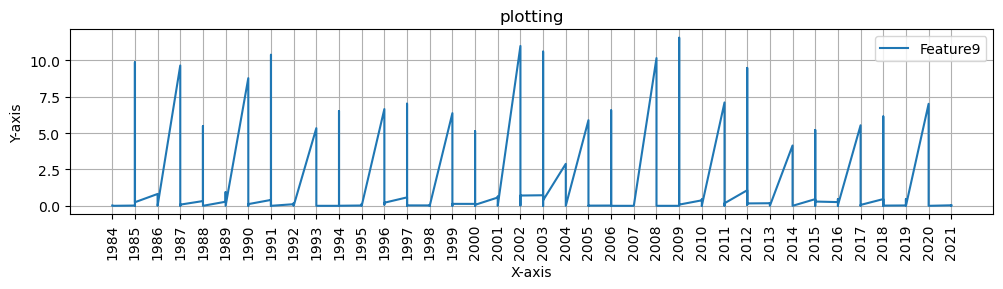

In [78]:
ploty(data["Year"],data[["Feature9"]], interval=35)

Calculates and displays average annual rate of change for both periods

In [79]:
# Calculate year-over-year differences for features
data['Feature1_change'] = data['Feature1'].diff()
data['Feature8_change'] = data['Feature8'].diff()

# Filter data for 2012 to 2019 and 2019 to 2021
before_2019 = data[(data['Year'] >= 2002) & (data['Year'] < 2019)]
from_2019_to_2021 = data[(data['Year'] >= 2019) & (data['Year'] <= 2021)]

# Calculate average annual rate of change for both periods
before_avg_change_f1 = before_2019['Feature1_change'].mean()
from_avg_change_f1 = from_2019_to_2021['Feature1_change'].mean()

before_avg_change_f8 = before_2019['Feature8_change'].mean()
from_avg_change_f8 = from_2019_to_2021['Feature8_change'].mean()

# Display the results
print("Feature1 - Average Annual Rate of Change:")
print(f"2002-2019: {before_avg_change_f1:.4f}")
print(f"2019-2021: {from_avg_change_f1:.4f}\n")

print("Feature8 - Average Annual Rate of Change:")
print(f"2002-2019: {before_avg_change_f8:.4f}")
print(f"2019-2021: {from_avg_change_f8:.4f}")

Feature1 - Average Annual Rate of Change:
2002-2019: -0.0002
2019-2021: 0.0008

Feature8 - Average Annual Rate of Change:
2002-2019: -0.0003
2019-2021: 0.0010


Vizualizing the Health Change Over the Yaers of the Glacier

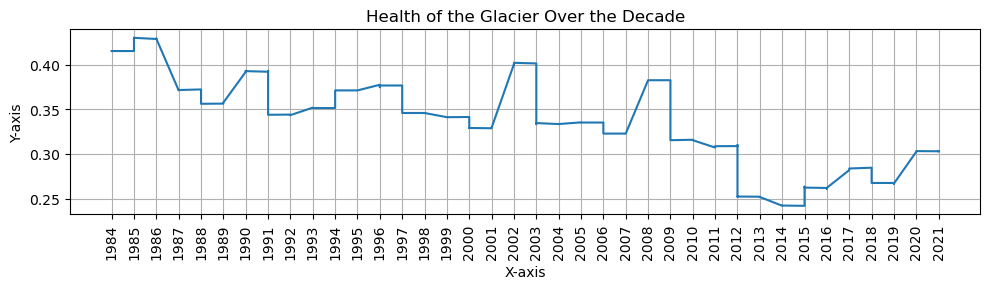

In [80]:
l1=list(data['Feature1'])

l2=list(data['Feature8'])


health=list(map(lambda x,y: np.mean(x+y), l1,l2))
ploty(data['Year'],health,interval=35,size2=1.5,size1=10,title="Health of the Glacier Over the Decade")

 Calculates the rate of change (slope) of a glacial health metric over two periods, 2002-2019 and 2019-2021, by fitting a linear regression model to the data for each period. The slope of the regression line represents the rate of change. A t-test is then performed to compare the slopes of the two periods to determine if there is a statistically significant difference. If the p-value from the t-test is less than 0.05, the difference in slopes is significant, indicating a change in the glacial health metric between the two periods.

In [81]:
# Sample Data
data['Period'] = np.where(data['Year'] < 2019, '2002-2019', '2019-2021')

# Define a function to calculate the rate of change (slope)
def calculate_slope(years, values):
    reg = LinearRegression()
    reg.fit(years.values.reshape(-1, 1), values)
    return reg.coef_[0]

# Calculate slopes for each period
slopes = {}
for period in data['Period'].unique():
    subset = data[data['Period'] == period]
    slope = calculate_slope(subset['Year'], subset['Feature1'])  # Replace with glacial health metric
    slopes[period] = slope
    print(f"Rate of change for {period}: {slope:.4f}")

# Perform a t-test to compare slopes
slope_2002_2019 = slopes['2002-2019']
slope_2019_2021 = slopes['2019-2021']

t_stat, p_value = ttest_ind([slope_2002_2019], [slope_2019_2021], equal_var=False)
print(f"\nT-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")



Rate of change for 2002-2019: -0.0016
Rate of change for 2019-2021: 0.0089

T-statistic: nan, P-value: nan


c:\Users\ASUS\anaconda3\envs\Ml_learning_env\Lib\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\ASUS\anaconda3\envs\Ml_learning_env\Lib\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Comparing the size of glaciers over two periods to see if their size has significantly reduced.

In [82]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming your DataFrame data has the following columns: ['Year', 'Feature1', 'Feature8']

# Filter data for 2002 to 2019 and 2019 to 2021
before_2019 = data[(data['Year'] >= 2002) & (data['Year'] < 2019)]
from_2019_to_2021 = data[(data['Year'] >= 2019) & (data['Year'] <= 2021)]

# Perform T-tests for Feature1 and Feature8
for feature in ['Feature1', 'Feature8','Feature9']:
    t_stat, p_value = ttest_ind(before_2019[feature], from_2019_to_2021[feature], equal_var=False)
    print(f"{feature} T-test:")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"Result: Significant change in {feature} between 2002–2019 and 2019–2021.\n")
    else:
        print(f"Result: No significant change in {feature} between 2009–2019 and 2019–2021.\n")

Feature1 T-test:
T-statistic: 3.8126, P-value: 0.0003
Result: Significant change in Feature1 between 2002–2019 and 2019–2021.

Feature8 T-test:
T-statistic: 3.9771, P-value: 0.0002
Result: Significant change in Feature8 between 2002–2019 and 2019–2021.

Feature9 T-test:
T-statistic: 0.9286, P-value: 0.3599
Result: No significant change in Feature9 between 2009–2019 and 2019–2021.



Understanding if the rate at which glaciers are shrinking has accelerated after 2019.

In [83]:
# T-test for Feature1
t_stat_f1, p_value_f1 = ttest_ind(before_2019['Feature1_change'].dropna(), 
                                  from_2019_to_2021['Feature1_change'].dropna())
print(f"\nFeature1 T-test: T-statistic = {t_stat_f1:.4f}, P-value = {p_value_f1:.4f}")

# T-test for Feature8
t_stat_f8, p_value_f8 = ttest_ind(before_2019['Feature8_change'].dropna(), 
                                  from_2019_to_2021['Feature8_change'].dropna())
print(f"Feature8 T-test: T-statistic = {t_stat_f8:.4f}, P-value = {p_value_f8:.4f}")


Feature1 T-test: T-statistic = -0.7818, P-value = 0.4355
Feature8 T-test: T-statistic = -0.7294, P-value = 0.4669


Here is the difference between the two code snippets presented in a grid format:

| **Aspect**                 | **First Code Snippet**                                              | **Second Code Snippet**                                         |
|----------------------------|--------------------------------------------------------------------|----------------------------------------------------------------|
| **Focus**                  | Compares raw feature values between periods                      | Compares year-over-year rate of change (`diff()`) between periods |
| **Comparison Basis**       | Absolute feature values                                          | Trends or rate of change                                       |
| **Feature Transformation** | None                                                             | Calculates year-over-year differences using `.diff()`          |
| **Insights Provided**      | Whether feature values differ significantly between periods      | Whether the trend or rate of change differs significantly between periods |
| **Statistical Test Input** | Raw values of features                                           | Year-over-year changes (derived from `diff()`)                |
| **Statistical Test Used**  | T-test for raw values                                            | T-test for rate of change                                      |
| **Additional Metrics**     | No additional metrics provided                                   | Calculates and displays average annual rate of change for both periods |
| **Suitable For**           | Understanding direct differences in feature levels              | Analyzing trends and directional changes                      |
| **Use Case Example**       | Comparing glacier size or pixel ratios over two periods         | Checking if glacier melting or ratio changes accelerated after 2019 |

This table highlights the methodological differences and when each approach might be more appropriate.

In [84]:
year=data['Year']
data.drop(['Year','Feature9','Feature1_change','Feature8_change','Period'],axis=1,inplace=True)


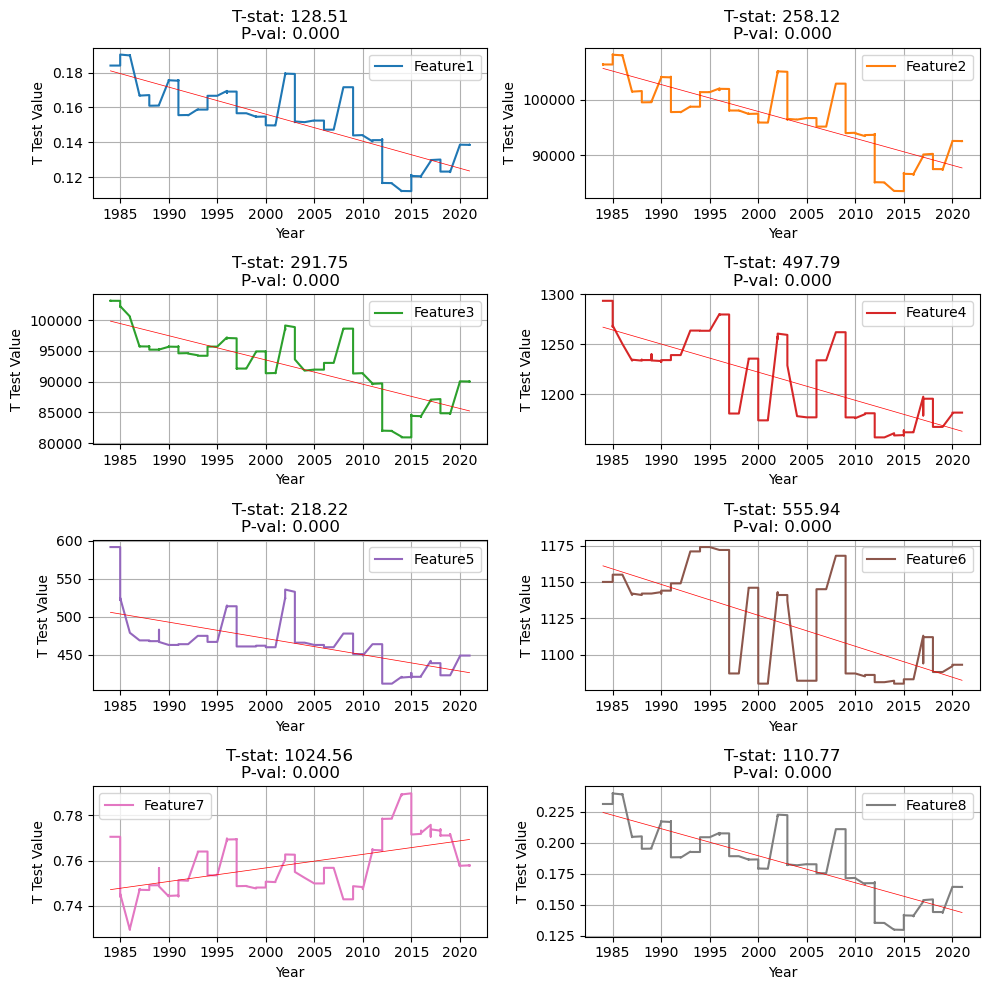

In [87]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

# Perform t-tests for each feature against a hypothetical population mean (e.g., 0)
results = {}
popmean = 0
for feature in data.columns:
    t_stat, p_val = ttest_1samp(data[feature].dropna(), popmean)  # Drop NaN if any
    results[feature] = (t_stat, p_val)

# Extracting t-statistics and p-values
t_stats = {feature: stat[0] for feature, stat in results.items()}
p_values = {feature: stat[1] for feature, stat in results.items()}

# Plotting the t-statistics for each feature with individual y-axis values
num_features = len(data.columns)
fig, axes = plt.subplots(4,2, figsize=(10, 10), sharey=False)  # Separate y-axis per plot

axes = axes.flatten()
for i, feature in enumerate(data.columns):
    x_data = year  # Use unique x-axis (years)
    y_data = data[feature]  # Individual y-axis data
    
    # Reshape x_data to 2D array for linear regression
    x_data_reshaped = x_data.values.reshape(-1, 1)
    y_data_values = y_data.values
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x_data_reshaped, y_data_values)
    
    # Predict y values using the model
    y_pred = model.predict(x_data_reshaped)

    # Plot the original data
    axes[i].plot(x_data, y_data, label=f'{feature}', color=f'C{i}')
    
    # Plot the best fit line
    axes[i].plot(x_data, y_pred, color='red', linestyle='-', linewidth=0.5, )

    # Set title with t-statistics and p-values
    axes[i].set_title(f'T-stat: {t_stats[feature]:.2f}\nP-val: {p_values[feature]:.3f}')
    axes[i].grid(True)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('T Test Value')
    axes[i].legend()

# Remove unused subplots (if any)
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [86]:
print(t_stats)
print(p_values)

{'Feature1': 128.51203986277565, 'Feature2': 258.1245180400647, 'Feature3': 291.7544072803364, 'Feature4': 497.7937166265904, 'Feature5': 218.21680198644162, 'Feature6': 555.9443411337377, 'Feature7': 1024.5599970733745, 'Feature8': 110.76685616576238}
{'Feature1': 1.0997735012354402e-263, 'Feature2': 0.0, 'Feature3': 0.0, 'Feature4': 0.0, 'Feature5': 0.0, 'Feature6': 0.0, 'Feature7': 0.0, 'Feature8': 8.708696880761709e-245}


The t-test results strongly reject the null hypothesis for all features, with extremely low p-values indicating that each feature is statistically significantly different from the hypothetical population mean. Feature7, with the highest t-statistic, stands out as having the most substantial deviation from the mean, while others like Feature1 and Feature8, although having lower t-statistics, still show strong significance. These results suggest that all features are meaningful and likely contain valuable information that is not centered around the population mean of 0.